<a href="https://colab.research.google.com/github/kei-mo/study-neural-field/blob/main/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


# Positional Encoding（高周波成分の表現を補助するためのエンコーディング）
class PositionalEncoding(nn.Module):
    def __init__(self, in_dim, num_freqs):
        super().__init__()
        self.num_freqs = num_freqs
        self.in_dim = in_dim

    def forward(self, x):
        # x: [N, in_dim]
        freq_bands = 2 ** torch.arange(self.num_freqs).float().to(
            x.device
        )  # 2^0, 2^1, ..., 2^(num_freqs-1)
        # x の各成分に対して sin と cos を計算する
        x_expanded = x.unsqueeze(-1) * freq_bands  # [N, in_dim, num_freqs]
        x_enc = torch.cat(
            [torch.sin(x_expanded), torch.cos(x_expanded)], dim=-1
        )  # [N, in_dim, 2*num_freqs]
        # 最後の次元を flatten して、元の x も結合する
        x_enc = x_enc.view(x.shape[0], -1)  # [N, in_dim * 2 * num_freqs]
        return torch.cat([x, x_enc], dim=-1)


# Neural Field を表す MLP の定義
class NeuralField(nn.Module):
    def __init__(self, in_dim=2, hidden_dim=256, out_dim=3, num_layers=4):
        super().__init__()
        layers = []
        layers.append(nn.Linear(in_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


# データセット作成関数：合成画像（ここではグラデーション画像）から座標とピクセル値を抽出
def create_dataset(image, device):
    # image: numpy 配列 [高さ, 幅, チャンネル]（[0,1]の範囲）
    H, W, C = image.shape
    x = np.linspace(0, 1, W)
    y = np.linspace(0, 1, H)
    grid_x, grid_y = np.meshgrid(x, y)
    coords = np.stack([grid_x, grid_y], axis=-1)  # [H, W, 2]
    coords = coords.reshape(-1, 2)
    pixels = image.reshape(-1, C)
    coords_tensor = torch.tensor(coords, dtype=torch.float32, device=device)
    pixels_tensor = torch.tensor(pixels, dtype=torch.float32, device=device)
    return coords_tensor, pixels_tensor


# 学習ループ
def train(model, optimizer, loss_fn, coords, pixels, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()
        pred = model(coords)
        loss = loss_fn(pred, pixels)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    return model


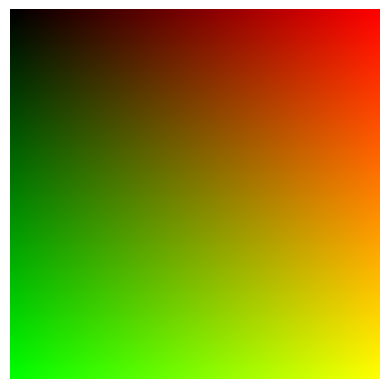

tensor([[0.0000, 0.0000],
        [0.0079, 0.0000],
        [0.0157, 0.0000],
        [0.0236, 0.0000],
        [0.0315, 0.0000],
        [0.0394, 0.0000],
        [0.0472, 0.0000],
        [0.0551, 0.0000],
        [0.0630, 0.0000],
        [0.0709, 0.0000]], device='cuda:0') tensor([[0.0000, 0.0000, 0.0000],
        [0.0079, 0.0000, 0.0000],
        [0.0157, 0.0000, 0.0000],
        [0.0236, 0.0000, 0.0000],
        [0.0315, 0.0000, 0.0000],
        [0.0394, 0.0000, 0.0000],
        [0.0472, 0.0000, 0.0000],
        [0.0551, 0.0000, 0.0000],
        [0.0630, 0.0000, 0.0000],
        [0.0709, 0.0000, 0.0000]], device='cuda:0')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 合成画像の作成：シンプルなグラデーション画像
H, W = 128, 128
x = np.linspace(0, 1, W)
y = np.linspace(0, 1, H)
grid_x, grid_y = np.meshgrid(x, y)
# 赤: x方向のグラデーション、緑: y方向のグラデーション、青: 0 の固定値
image = np.stack([grid_x, grid_y, np.zeros_like(grid_x)], axis=-1)  # [H, W, 3]
plt.imshow(image)
plt.axis("off")
plt.show()

# 座標とピクセル値のデータセットを作成
coords, pixels = create_dataset(image, device)
print(coords[:10], pixels[:10])

Epoch 0, Loss: 0.2150
Epoch 100, Loss: 0.0003
Epoch 200, Loss: 0.0001
Epoch 300, Loss: 0.0001
Epoch 400, Loss: 0.0001
Epoch 500, Loss: 0.0000
Epoch 600, Loss: 0.0000
Epoch 700, Loss: 0.0000
Epoch 800, Loss: 0.0000
Epoch 900, Loss: 0.0000


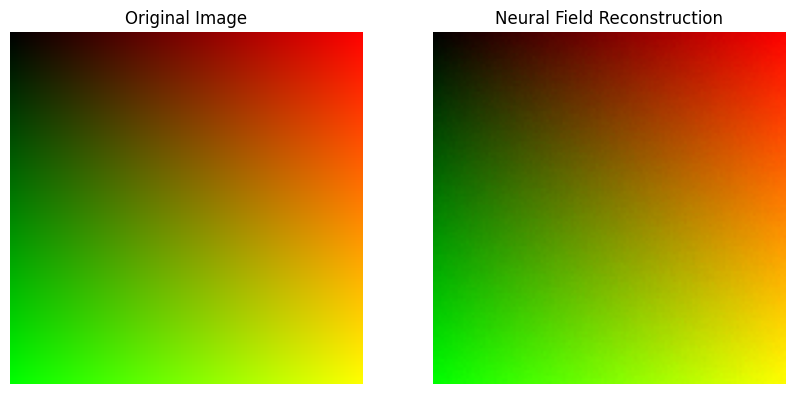

In [ ]:
# Positional Encoding の設定
num_freqs = 10
pos_enc = PositionalEncoding(in_dim=2, num_freqs=num_freqs)
# 入力次元は、元の 2 次元 + Positional Encoding による次元 (2 * 2 * num_freqs) = 4*num_freqs
in_dim = 2 + 4 * num_freqs
base_model = NeuralField(in_dim=in_dim, hidden_dim=256, out_dim=3, num_layers=4).to(
    device
)


# Positional Encoding と MLP を組み合わせたモデル
class NeuralFieldWithPE(nn.Module):
    def __init__(self, pos_enc, model):
        super().__init__()
        self.pos_enc = pos_enc
        self.model = model

    def forward(self, x):
        x_enc = self.pos_enc(x)
        return self.model(x_enc)


model = NeuralFieldWithPE(pos_enc, base_model).to(device)

# 学習パラメータの設定
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# モデルの学習
model.train()
model = train(model, optimizer, loss_fn, coords, pixels, epochs=1000)

# モデル評価：学習済みの Neural Field から画像を再構成
model.eval()
with torch.no_grad():
    pred_pixels = model(coords).cpu().numpy()
pred_image = pred_pixels.reshape(H, W, 3)

# 結果のプロット：元画像と再構成画像の比較
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")
axs[1].imshow(np.clip(pred_image, 0, 1))
axs[1].set_title("Neural Field Reconstruction")
axs[1].axis("off")
plt.show()
